In [3]:
import sys
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import xarray as xr
from scipy.spatial import cKDTree

# lexi's overlap algorithm

In [ ]:
def fix_overlaps_2d(df, repo, max_iters = 2000, ini_d_adj = 0.01, lr = 0.8):
    """
    Adjust diameters so that no two particles overlap. Before doing this, shrink the 
    particle diameter by the bond_skin_thickness. By design, in the packing process,
    particles are created too large by the bond_skin_thickness. 

    df must have columns: ['x', 'y', 'd', 'type']
    """
    # TODO: modify to make only adjust diameters for type 2 partilce
    # initial parameters
    coords = df[['x', 'y']].to_numpy()
    mean_d = df['d'].mean()
    particle_types = df['type'].to_numpy()
    diam_adj = mean_d*ini_d_adj
    overlaps_remaining = []

    # dynamic growth rate stuff
    gradient_flag=False
    min_adj = 1

    n = len(coords)
    for iteration in range(max_iters):
        if iteration >= 2 and gradient_flag == False:
            x = np.arange(iteration)
            doverlaps_dx = np.gradient(overlaps_remaining)
            if np.any(doverlaps_dx < 0):
                gradient_flag=True
        if gradient_flag:
            diam_adj *= lr
            diam_adj = np.maximum(diam_adj, min_adj)
        n_overlaps_this_pass = 0
        radii = 0.5 * df['d'].to_numpy()
        for i in range(n):
            distances = np.sqrt(np.sum((coords[i] - coords)**2, axis=1))
            # Indices of all particles that overlap with particle i
            overlap_indices = np.where((distances < (radii[i] + radii)) & (distances > 0))[0]
            if (overlap_indices.size > 0) and (particle_types[i] == 1): # if overlap and interior particle
                n_overlaps_this_pass += 1
                df.loc[i+1, 'd'] -= diam_adj + 1e-5 # adjust diameter at index label i+1 = coords[i]
        overlaps_remaining.append(n_overlaps_this_pass)
        if n_overlaps_this_pass == 0:
            print(f'[INFO] Converged at iteration # = {iteration}')
            break
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.arange(1, len(overlaps_remaining)+1), overlaps_remaining, color = 'b')
    ax.grid()
    ax.set_xlabel('Iteration #')
    ax.set_ylabel('# Fixed Overlaps')
    plt.show()
    plt.savefig(os.path.join(repo, f'overlaps_newfunc_{ini_d_adj}.jpg'), dpi=300, bbox_inches='tight')
    return df

def get_line(xi, xf, yi, yf, d):
    """
    Computes x and y coordinates of particles along a line from (x_i, y_i) to 
    (x_f, y_f) for particles of diameter size d.
    """
    lenx = xf - xi
    leny = yf - yi
    len = np.sqrt(lenx**2 + leny**2)
    n_atoms = int(np.floor(len/d))
    x = np.linspace(xi, xf, n_atoms)
    y = np.linspace(yi, yf, n_atoms)
    return np.array([x, y])

def get_bdy_particles_coords(d, density, include_top_bot_boundaries=False):
    """
    Returns a dataframe containing the coordinates of the boundary particles of
    the Danseraeu et al. (2017) fjord geometry. Wall #1 is bottom left wall and #s
    move clockwise around the geometry. Delete walls 5 and 10 for an open fjord.
    IN: d = diameter of boundary particles (m). If polydisperse, use the mean diameter.
    IN: include_top_bot_boundaries = boolean (opt) include top and bottom boundaries of fjord.
    OUT: pd.DataFrame with columns ['x', 'y'] containing particle coordinates.
    """
    # Convert diameter from m to km
    d_km = d / 1000.0
    r_km = d_km / 2.0 + 0.1 # radius in km; make a little smaller for faster convergence

    # Define wall numbers
    wall_numbers = np.arange(1, 11)  # 1..10

    # Initial and final coordinates for each wall (in km)
    x_i = np.array([  0,  40,  40,   0,   0, 120, 120,  80,  80, 120], dtype=float)
    x_f = np.array([ 40,  40,   0,   0, 120, 120,  80,  80, 120,   0], dtype=float)
    y_i = np.array([  0,  80, 120, 160, 245, 247, 160, 120,  80,   0], dtype=float)
    y_f = np.array([ 80, 120, 160, 245, 245, 160, 120,  80,   0,   0], dtype=float)

    # Create an xarray dataset
    ds = xr.Dataset(
        {
            "x_i": ("wall", x_i),
            "x_f": ("wall", x_f),
            "y_i": ("wall", y_i),
            "y_f": ("wall", y_f),
        },
        coords={"wall": wall_numbers},
    )

    # Optionally exclude top and bottom walls
    if not include_top_bot_boundaries:
        ds = ds.sel(wall=ds.wall[np.isin(ds.wall, [5, 10], invert=True)])

    # Collect all x,y in lists
    all_x = []
    all_y = []
    for w in ds.wall.values:
        xi = ds.x_i.sel(wall=w).item()
        xf = ds.x_f.sel(wall=w).item()
        yi = ds.y_i.sel(wall=w).item()
        yf = ds.y_f.sel(wall=w).item()
        # 1) get the "center line" coordinates spaced by 'd_km'
        x_line, y_line = get_line(xi, xf, yi, yf, d_km)
        # 2) compute the direction vector and length
        dx = xf - xi
        dy = yf - yi
        length = np.sqrt(dx**2 + dy**2)
        if length == 0:
            # check if wall length is degenerate
            continue
        # 3) Get normals
        nx =  dy / length  
        ny = -dx / length  
        # 4) shift by the radius (km) so that bdy particles are outside fjord bdy
        x_vals = x_line - r_km * nx
        y_vals = y_line - r_km * ny
        # Delete overlapping particles at corners; will still have overlap if wall length % diameter != 0
        # This is ok because these boundary particles will not be integrated
        x_vals = x_vals[1:]
        y_vals = y_vals[1:]
        # Accumulate
        all_x.extend(x_vals)
        all_y.extend(y_vals)

    # Fix units
    all_x = np.array(all_x)*1e3
    all_y = np.array(all_y)*1e3
    # Create a DataFrame
    df_bdy = pd.DataFrame({"x": all_x, "y": all_y})
    df_bdy["id"] = range(1, len(df_bdy) + 1)
    df_bdy = df_bdy.set_index("id")
    df_bdy["type"] = 2*np.ones_like(df_bdy["x"])
    df_bdy["density"] = density*np.ones_like(df_bdy["x"])
    df_bdy["d"] = d*np.ones_like(df_bdy["x"])
    df_bdy["z"] = np.zeros_like(df_bdy["x"])
    return df_bdy

# ---------------------------------- check --------------------------------------- #
def check_all_overlaps(df):
    #df = df[df['type'] == 1] # only checking interior particles
    coords = df[['x', 'y']].to_numpy()
    n = len(coords)
    radii = 0.5 * df['d'].to_numpy()
    overlaps = []
    # Compare each circle with every other circle
    for i in range(n):
        distances = np.sqrt(np.sum((coords[i] - coords)**2, axis=1))
        # Indices of other circles that overlap with the current circle (distance < 1.0 and not comparing with itself)
        overlap_indices = np.where((distances < (radii[i] + radii)) & (distances > 0))[0]
        for j in overlap_indices:
            # Ensure each pair is added only once (i < j ensures that)
            #if i < j:
            overlaps.append((i, j))
    return overlaps

[INFO] Converged at iteration # = 490


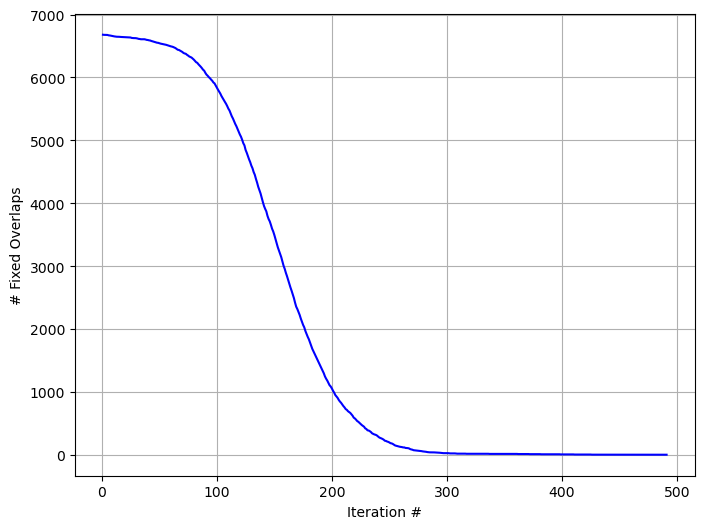

In [29]:
# HARD CODING BE CAREFUL
d = 2000
density = 920
bond_skin_thickness = 0.001*2200

# Construct file paths
original_fpath = 'data/packing2km.data'
repo = 'testing'

# (1) Read original .data file

# Read atom data until we hit velocities
column_names = ['type', 'x', 'y', 'z', 'd', 'density']
rows_to_skip = 21
cutoff_line = None
with open(original_fpath, 'r') as f:
    for i, line in enumerate(f):
        if "Velocities" in line:
            cutoff_line = i - 1
            break
rows_to_read = cutoff_line - rows_to_skip if cutoff_line is not None else None
df_int = pd.read_csv(original_fpath, sep=r'\s+', usecols=[1, 2, 3, 4, 5, 6],
                skiprows=rows_to_skip, nrows=rows_to_read,
                names=column_names)

# Reformat dataframe so we're ready to read it out
df_int["id"] = range(1, len(df_int) + 1)
df_int = df_int.set_index("id")

# (2) Get boundary particles
df_bdy = get_bdy_particles_coords(d, density)

# (3) Fix Overlaps

# 3.1 Delete atoms at the very edge that got uplifted
df_int = df_int[df_int['z'] <= -4000] # careful of hard coding here!!!! number from visual inspection in Ovito
df_int['z'] = np.zeros_like(df_int['z'])
#df_int.index = range(1, len(df_int) + 1) # reindex dataframe so that fix overlaps still works

# 3.2 Run overlap code
df_int['d'] -= bond_skin_thickness # preliminary diameter adjustment

# concatenate interior and boundary particle dataframes
df = pd.concat([df_bdy, df_int], ignore_index=True)
df.index=range(1,len(df)+1)
overlaps_rem, df = fix_overlaps_2d(df, repo)

### check overlaps

8 overlaps found


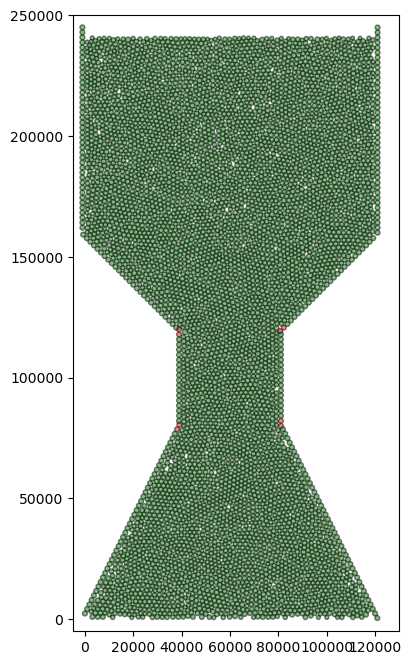

In [30]:
# Check for any overlap
olap = check_all_overlaps(df)
overlap = np.unique(olap)
print(len(overlap), 'overlaps found')
fig, ax = plt.subplots(figsize = (8,8))

for index, row in df.iterrows():
    color = 'red' if np.isin(index, olap) else 'g' # i think this code is messed up.....
    circle = plt.Circle((row['x'], row['y']), row['d']/2, edgecolor ='k', facecolor = color, alpha = 0.5)
    ax.add_artist(circle)

ax.set_xlim(-5e3, 130e3)
ax.set_ylim(-5e3, 250e3)
ax.set_aspect('equal')
plt.show()

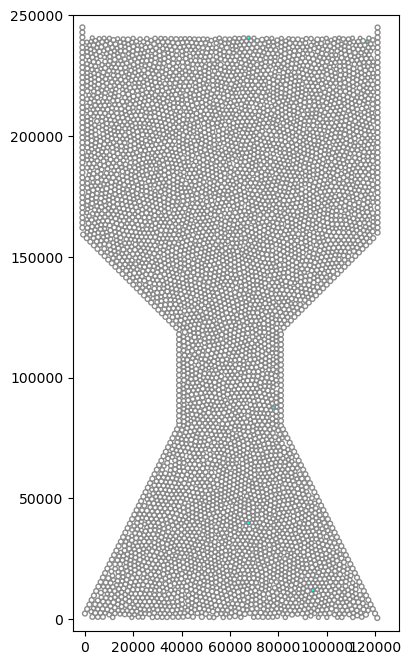

In [33]:
fig, ax = plt.subplots(figsize = (8,8))
for index, row in df.iterrows():
    color = 'cyan' if row['d']<1450 else 'white' # i think this code is messed up.....
    circle = plt.Circle((row['x'], row['y']), row['d']/2, edgecolor ='grey', facecolor = color, alpha = 0.9)
    ax.add_artist(circle)

ax.set_xlim(-5e3, 130e3)
ax.set_ylim(-5e3, 250e3)
ax.set_aspect('equal')
plt.show()

### plot particle distribution

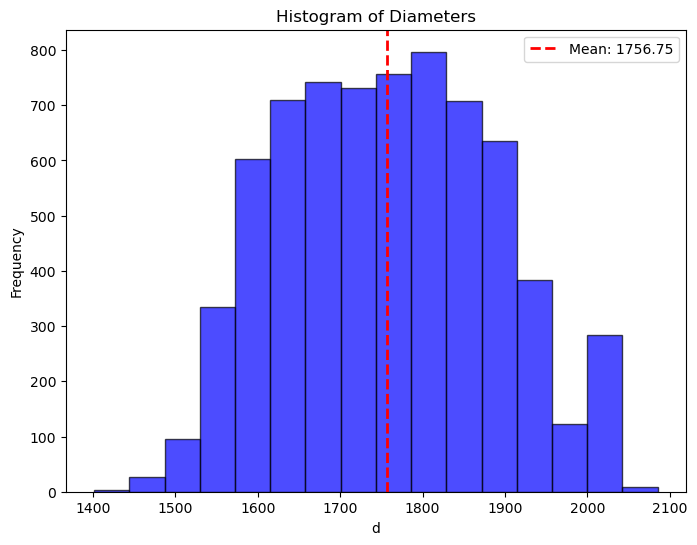

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df['d'], bins=16, color='blue', edgecolor='black', alpha=0.7)
ax.axvline(df['d'].mean(), color='red', linestyle='--', linewidth=2,
        label=f'Mean: {df['d'].mean():.2f}')
ax.set_xlabel('d')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Diameters')
ax.legend()

this is looking awesome!

# pre 2/13/25 stuff

In [7]:

def update_growth(df, df_bdy, growth_rate, bdy_radius, tol):
    """
    Check for each free particle whether growing its radius by growth_rate
    would cause an overlap with any other free particle or a boundary particle.
    
    Returns a boolean array (length = number of free particles) indicating which particles can grow.
    """
    n = len(df)
    can_grow = np.ones(n, dtype=bool)
    
    # Get free particle positions and current radii as arrays.
    positions = df[['x','y']].to_numpy()
    radii = df['radius'].to_numpy()

    # Compare each free particle to all others (we can use a double loop, or optimize via vectorization).
    for i in range(n):
        new_radius = radii[i] + growth_rate
        for j in range(n):
            if i == j:
                continue
            # Compute Euclidean distance between particle i and particle j.
            dist = np.sqrt((positions[i,0] - positions[j,0])**2 + (positions[i,1] - positions[j,1])**2)
            # Check: if particle i grows, will it overlap with particle j (which is not growing this step)?
            if particles_touch(new_radius, radii[j], dist, tol=-tol):  
                # We subtract a tiny tolerance (or add a negative tol) so that we allow nearly touching
                can_grow[i] = False
                break  # no need to check other free particles
        
        # Also check against all boundary particles.
        if can_grow[i]:
            for _, bdy in df_bdy.iterrows():
                dist = np.sqrt((positions[i,0] - bdy['x'])**2 + (positions[i,1] - bdy['y'])**2)
                if particles_touch(new_radius, bdy_radius, dist, tol=-tol):
                    can_grow[i] = False
                    break
    return can_grow

def particles_touch(r1, r2, dist, tol=0):
    """Return True if two particles (with radii r1 and r2) are at or below the touching condition.
       Optionally a tolerance can be added.
    """
    return dist <= (r1 + r2 + tol)

def get_diameters(df, df_bdy):
    # Set initial radii for free particles (diameter = 1000 -> radius = 500)
    df['radius'] = 500.0

    # Boundary particles have a fixed diameter of 2000 -> radius = 1000.
    bdy_radius = 1000.0

    # Parameters for growth:
    growth_rate = 100.0      # initial growth step in meters
    min_growth_rate = 0.1    # stop when the growth step is very small
    tolerance = 1e-5         # a tolerance for “touching” condition

    # Iteratively grow the particles.
    while growth_rate > min_growth_rate:
        # Determine which particles can safely grow without overlapping.
        grow_flags = update_growth(df, df_bdy, growth_rate, bdy_radius, tolerance)
        
        if not np.any(grow_flags):
            # If none of the free particles can grow with the current growth_rate, reduce the step.
            growth_rate /= 2.0
            print(f"Reducing growth rate to {growth_rate:.4f} m")
        else:
            # Grow only those particles that are free to grow.
            df.loc[grow_flags, 'radius'] += growth_rate
            print(f"Grew {grow_flags.sum()} particles by {growth_rate} m")
        
        # Optionally, add a stopping condition if all particles cannot grow further.
        if not np.any(grow_flags) and growth_rate <= min_growth_rate:
            break

    df['d'] = 2 * df['radius']

    return df

def get_line(xi, xf, yi, yf, d):
    """
    Computes x and y coordinates of particles along a line from (x_i, y_i) to 
    (x_f, y_f) for particles of diameter size d.
    """
    lenx = xf - xi
    leny = yf - yi
    len = np.sqrt(lenx**2 + leny**2)
    n_atoms = int(np.floor(len/d))
    x = np.linspace(xi, xf, n_atoms)
    y = np.linspace(yi, yf, n_atoms)
    return np.array([x, y])

def get_bdy_particles_coords(d, include_top_bot_boundaries=False):
    """
    Returns a dataframe containing the coordinates of the boundary particles of
    the Danseraeu et al. (2017) fjord geometry. Wall #1 is bottom left wall and #s
    move clockwise around the geometry. Delete walls 5 and 10 for an open fjord.
    IN: d = diameter of boundary particles (m). If polydisperse, use the mean diameter.
    IN: include_top_bot_boundaries = boolean (opt) include top and bottom boundaries of fjord.
    OUT: pd.DataFrame with columns ['x', 'y'] containing particle coordinates.
    """
    # Convert diameter from m to km
    d_km = d / 1000.0
    r_km = d_km / 2.0 + 0.15    # radius in km

    # Define wall numbers
    wall_numbers = np.arange(1, 11)  # 1..10

    # Initial and final coordinates for each wall (in km)
    x_i = np.array([  0,  40,  40,   0,   0, 120, 120,  80,  80, 120], dtype=float)
    x_f = np.array([ 40,  40,   0,   0, 120, 120,  80,  80, 120,   0], dtype=float)
    y_i = np.array([  0,  80, 120, 160, 245, 247, 160, 120,  80,   0], dtype=float)
    y_f = np.array([ 80, 120, 160, 245, 245, 160, 120,  80,   0,   0], dtype=float)

    # Create an xarray dataset
    ds = xr.Dataset(
        {
            "x_i": ("wall", x_i),
            "x_f": ("wall", x_f),
            "y_i": ("wall", y_i),
            "y_f": ("wall", y_f),
        },
        coords={"wall": wall_numbers},
    )

    # Optionally exclude top and bottom walls
    if not include_top_bot_boundaries:
        ds = ds.sel(wall=ds.wall[np.isin(ds.wall, [5, 10], invert=True)])

    # Collect all x,y in lists
    all_x = []
    all_y = []
    for w in ds.wall.values:
        xi = ds.x_i.sel(wall=w).item()
        xf = ds.x_f.sel(wall=w).item()
        yi = ds.y_i.sel(wall=w).item()
        yf = ds.y_f.sel(wall=w).item()
        # 1) get the "center line" coordinates spaced by 'd_km'
        x_line, y_line = get_line(xi, xf, yi, yf, d_km)
        # 2) compute the direction vector and length
        dx = xf - xi
        dy = yf - yi
        length = np.sqrt(dx**2 + dy**2)
        if length == 0:
            # check if wall length is degenerate
            continue
        # 3) Get normals
        nx =  dy / length  
        ny = -dx / length  
        # 4) shift by the radius (km) so that bdy particles are outside fjord bdy
        x_vals = x_line - r_km * nx
        y_vals = y_line - r_km * ny
        # Delete overlapping particles at corners; will still have overlap if wall length % diameter != 0
        # This is ok because these boundary particles will not be integrated
        x_vals = x_vals[1:]
        y_vals = y_vals[1:]
        # Accumulate
        all_x.extend(x_vals)
        all_y.extend(y_vals)

    # Fix units
    all_x = np.array(all_x)*1e3
    all_y = np.array(all_y)*1e3
    # Create a DataFrame
    df_bdy = pd.DataFrame({"x": all_x, "y": all_y})
    df_bdy["id"] = range(1, len(df_bdy) + 1)
    df_bdy = df_bdy.set_index("id")
    return df_bdy

In [4]:
# (1) Read original .data file

original_fpath = 'data/packing2km.data'

# Read atom data until we hit velocities
column_names = ['type', 'x', 'y', 'z', 'd', 'density']
rows_to_skip = 21
cutoff_line = None
with open(original_fpath, 'r') as f:
    for i, line in enumerate(f):
        if "Velocities" in line:
            cutoff_line = i - 1
            break
rows_to_read = cutoff_line - rows_to_skip if cutoff_line is not None else None
df = pd.read_csv(original_fpath, sep=r'\s+', usecols=[1, 2, 3, 4, 5, 6],
                skiprows=rows_to_skip, nrows=rows_to_read,
                names=column_names)

# Reformat dataframe so we're ready to read it out
df["id"] = range(1, len(df) + 1)
df = df.set_index("id")
df["bond_type"] = 1

# (2) Set parameters to install bonds on fake atoms to allow successful import
# These will be deleted upon import so overlap is ok
d = 2000                          # hard coding be careful!!!
density = 920   # hard coding be careful!!!

# (2) Get boundary particles
df_bdy = get_bdy_particles_coords(d)

# (3) Fix Overlaps

# 3.1 Delete atoms at the very edge that got uplifted
df = df[df['z'] <= -4000] # careful of hard coding here!!!! number from visual inspection in Ovito
df.index = range(1, len(df) + 1) # reindex dataframe so that fix overlaps still works

# 3.2 Run dilation code
df = get_diameters(df, df_bdy)

Grew 6680 particles by 100.0 m
Grew 6680 particles by 100.0 m
Grew 6665 particles by 100.0 m
Grew 4054 particles by 100.0 m
Grew 206 particles by 100.0 m
Grew 10 particles by 100.0 m
Reducing growth rate to 50.0000 m
Grew 1557 particles by 50.0 m
Reducing growth rate to 25.0000 m
Grew 1344 particles by 25.0 m
Reducing growth rate to 12.5000 m
Grew 1233 particles by 12.5 m
Reducing growth rate to 6.2500 m
Grew 1131 particles by 6.25 m
Reducing growth rate to 3.1250 m
Grew 937 particles by 3.125 m
Reducing growth rate to 1.5625 m
Grew 891 particles by 1.5625 m
Reducing growth rate to 0.7812 m
Grew 796 particles by 0.78125 m
Reducing growth rate to 0.3906 m
Grew 699 particles by 0.390625 m
Reducing growth rate to 0.1953 m
Grew 657 particles by 0.1953125 m
Reducing growth rate to 0.0977 m


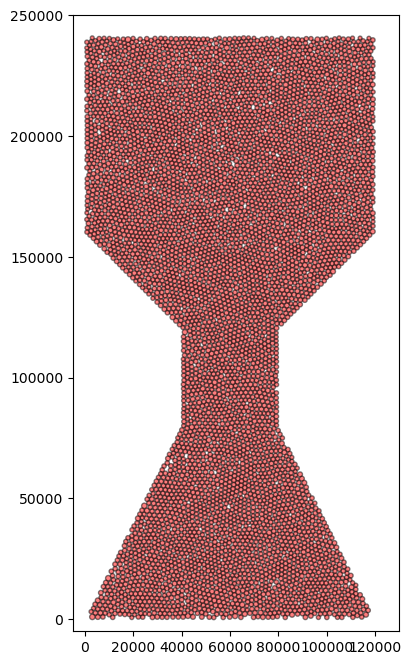

In [5]:
fig, ax = plt.subplots(figsize = (8,8))

for index, row in df.iterrows():
    color = 'red' #if np.isin(index, olap) else 'g' # i think this code is messed up.....
    circle = plt.Circle((row['x'], row['y']), row['d']/2, edgecolor ='k', facecolor = color, alpha = 0.5)
    ax.add_artist(circle)

ax.set_xlim(-5e3, 130e3)
ax.set_ylim(-5e3, 250e3)
# ax.set_xlim(40e3, 80e3)
# ax.set_ylim(80e3, 100e3)
ax.set_aspect('equal')
plt.show()

In [8]:
ds = df.to_xarray()
ds.to_netcdf(r'c:\Users\arlenlex\Documents\packing2km_dilation.data')

In [14]:
df['d'].max()

np.float64(2300.0)

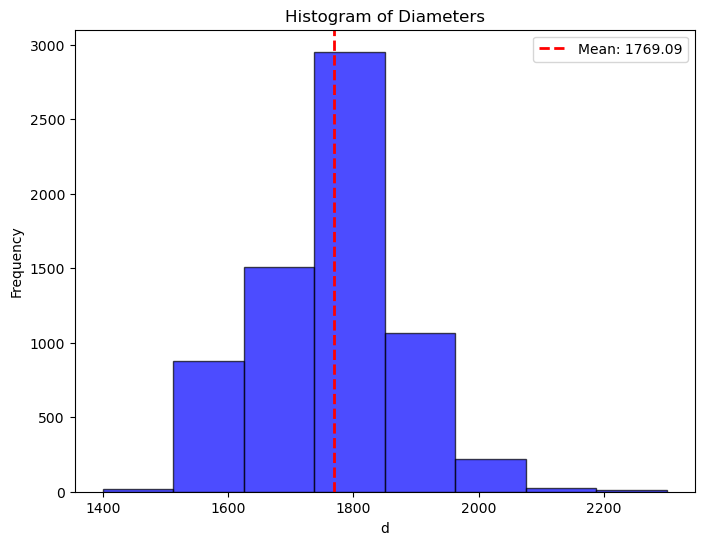

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df['d'], bins=8, color='blue', edgecolor='black', alpha=0.7)
ax.axvline(df['d'].mean(), color='red', linestyle='--', linewidth=2,
        label=f'Mean: {df['d'].mean():.2f}')
ax.set_xlabel('d')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Diameters')
ax.legend()

a more efficient example by chat gpt

In [ ]:
def update_growth_kdtree(df, df_bdy, growth_rate, bdy_radius, tol):
    """
    For each free particle, check (using cKDTree) if increasing its radius
    by 'growth_rate' would cause overlap with any other free particle or boundary.
    Returns a boolean array indicating which particles can grow.
    """
    positions = df[['x', 'y']].to_numpy()
    radii = df['radius'].to_numpy()
    n = len(df)
    can_grow = np.ones(n, dtype=bool)
    
    # Build a KDTree for the current positions
    tree = cKDTree(positions)
    
    for i in range(n):
        new_r = radii[i] + growth_rate
        # Query neighboring particles that are within a search radius.
        # We use new_r + max(radii) as a conservative search radius.
        indices = tree.query_ball_point(positions[i], new_r + np.max(radii))
        for j in indices:
            if i == j:
                continue
            d_ij = np.linalg.norm(positions[i] - positions[j])
            # Check if after growth the particle would overlap with neighbor j.
            # We allow “near touching” by using a small tolerance.
            if d_ij <= (new_r + radii[j] - tol):
                can_grow[i] = False
                break
        # Also check against boundary particles.
        for _, bdy in df_bdy.iterrows():
            d_bdy = np.linalg.norm(positions[i] - np.array([bdy['x'], bdy['y']]))
            if d_bdy <= (new_r + bdy_radius - tol):
                can_grow[i] = False
                break
    return can_grow

def update_growth_kdtree_sync(df, df_bdy, growth_rate, bdy_radius, tol):
    """
    Synchronous update: check for each free particle whether increasing its radius by growth_rate
    (and assuming all neighbors also grow by growth_rate) would cause overlap.
    Returns a boolean array indicating which particles can grow.
    """
    positions = df[['x', 'y']].to_numpy()
    radii = df['radius'].to_numpy()
    n = len(df)
    can_grow = np.ones(n, dtype=bool)
    
    # Build a KDTree for current positions.
    tree = cKDTree(positions)
    
    # Note: The search radius now should consider both particles growing.
    search_radius = growth_rate + np.max(radii + growth_rate)
    
    for i in range(n):
        # Proposed new radius for particle i:
        new_r_i = radii[i] + growth_rate
        indices = tree.query_ball_point(positions[i], search_radius)
        for j in indices:
            if i == j:
                continue
            d_ij = np.linalg.norm(positions[i] - positions[j])
            # For a safe synchronous update, assume neighbor j will also grow by growth_rate.
            if d_ij < (radii[i] + growth_rate + radii[j] + growth_rate - tol):
                can_grow[i] = False
                break
        # Also check boundary particles (they do not grow).
        for _, bdy in df_bdy.iterrows():
            d_bdy = np.linalg.norm(positions[i] - np.array([bdy['x'], bdy['y']]))
            # Boundary particles remain at fixed radius (bdy_radius).
            if d_bdy < (new_r_i + bdy_radius - tol):
                can_grow[i] = False
                break
    return can_grow

def get_diameters(df, df_bdy, growth_rate = 100, bdy_radius = 1000, tol = 1e-5, min_growth_rate = 0.1):

    # Compute the initial radii from diameters
    df['radius'] = df['d'] / 2.0

    # -----------------------------------------------
    # 2. Pre-Processing: Remove Initial Overlaps via Shrinkage
    # -----------------------------------------------

    # Build a KDTree for the free particles
    positions = df[['x', 'y']].to_numpy()
    radii = df['radius'].to_numpy()
    tree = cKDTree(positions)

    # The idea: for every pair of particles that are overlapping (i.e. distance < r_i + r_j)
    # compute the “overlap amount” and determine a uniform shrink value (delta) that
    # when subtracted from each particle’s radius will remove all overlaps.
    delta_required = 0.0
    # We search for pairs that could possibly overlap.
    # (Using a search radius that is at least as large as twice the maximum radius.)
    max_possible = np.max(radii) * 2
    overlap_pairs = tree.query_pairs(r=max_possible)

    for i, j in overlap_pairs:
        d_ij = np.linalg.norm(positions[i] - positions[j])
        # If the particles overlap, the condition is: (r_i + r_j) > d_ij.
        overlap = (radii[i] + radii[j]) - d_ij
        if overlap > 0:
            # For a uniform shrink, each particle would need to lose half of the overlap.
            delta_required = max(delta_required, overlap / 2)

    if delta_required > 0:
        shrink_amount = delta_required + tol  # add a small extra to be safe
        print(f"Initial overlap detected. Shrinking all radii by {shrink_amount:.4f} m.")
        df['radius'] = df['radius'] - shrink_amount
        # Recompute the diameters from the new radii.
        df['d'] = 2 * df['radius']
    else:
        print("No initial overlaps detected.")

    # -----------------------------------------------------------
    # 3. Iterative Dilation Using SciPy’s cKDTree for Efficiency
    # -----------------------------------------------------------

    # Here we “grow” the particles until they are nearly touching each other or a boundary.
    growth_rate = 100.0       # initial growth step (in meters)
    min_growth_rate = 0.1     # stop when the growth step becomes very small
    # Iteratively grow the particles.
    while growth_rate > min_growth_rate:
        grow_flags = update_growth_kdtree_sync(df, df_bdy, growth_rate, bdy_radius, tol)
        
        if not np.any(grow_flags):
            # If none of the particles can safely grow with the current growth_rate, reduce it.
            growth_rate /= 2.0
            print(f"Reducing growth rate to {growth_rate:.4f} m")
        else:
            # Grow only the particles that can safely grow.
            df.loc[grow_flags, 'radius'] += growth_rate/2 # divide by 2 because growing all particles together
            print(f"Grew {grow_flags.sum()} particles by {growth_rate/2:.4f} m")
        
        # Optional stopping condition: if no particle can grow and the step is small, break.
        if not np.any(grow_flags) and growth_rate <= min_growth_rate:
            break

    # After dilation, update the diameter column.
    df['d'] = 2 * df['radius']

    return df

In [9]:
original_fpath = 'data/packing2km.data'

# Read atom data until we hit velocities
column_names = ['type', 'x', 'y', 'z', 'd', 'density']
rows_to_skip = 21
cutoff_line = None
with open(original_fpath, 'r') as f:
    for i, line in enumerate(f):
        if "Velocities" in line:
            cutoff_line = i - 1
            break
rows_to_read = cutoff_line - rows_to_skip if cutoff_line is not None else None
df2 = pd.read_csv(original_fpath, sep=r'\s+', usecols=[1, 2, 3, 4, 5, 6],
                skiprows=rows_to_skip, nrows=rows_to_read,
                names=column_names)

# Reformat dataframe so we're ready to read it out
df2["id"] = range(1, len(df2) + 1)
df2 = df2.set_index("id")
df2["bond_type"] = 1

# (2) Set parameters to install bonds on fake atoms to allow successful import
# These will be deleted upon import so overlap is ok
d = 2000                          # hard coding be careful!!!
density = 920   # hard coding be careful!!!

# (2) Get boundary particles
df_bdy = get_bdy_particles_coords(d)

# (3) Fix Overlaps

# 3.1 Delete atoms at the very edge that got uplifted
df2 = df2[df2['z'] <= -4000] # careful of hard coding here!!!! number from visual inspection in Ovito
df2.index = range(1, len(df2) + 1) # reindex dataframe so that fix overlaps still works

In [10]:
df2_fixed = get_diameters(df2, df_bdy)

Grew 6680 particles by 100.0 m
Grew 6680 particles by 100.0 m
Grew 6665 particles by 100.0 m
Grew 4054 particles by 100.0 m
Grew 206 particles by 100.0 m
Grew 10 particles by 100.0 m
Reducing growth rate to 50.0000 m
Grew 1557 particles by 50.0 m
Reducing growth rate to 25.0000 m
Grew 1344 particles by 25.0 m
Reducing growth rate to 12.5000 m
Grew 1233 particles by 12.5 m
Reducing growth rate to 6.2500 m
Grew 1131 particles by 6.25 m
Reducing growth rate to 3.1250 m
Grew 937 particles by 3.125 m
Reducing growth rate to 1.5625 m
Grew 891 particles by 1.5625 m
Reducing growth rate to 0.7812 m
Grew 796 particles by 0.78125 m
Reducing growth rate to 0.3906 m
Grew 699 particles by 0.390625 m
Reducing growth rate to 0.1953 m
Grew 657 particles by 0.1953125 m
Reducing growth rate to 0.0977 m


In [11]:
def check_all_overlaps(df):
    df = df[df['type'] == 1]
    coords = df[['x', 'y']].to_numpy()
    n = len(coords)
    radii = 0.5 * df['d'].to_numpy()
    print(2 * radii.mean())
    overlaps = []
    # Compare each circle with every other circle
    for i in range(n):
        distances = np.sqrt(np.sum((coords[i] - coords)**2, axis=1))
        # Indices of other circles that overlap with the current circle (distance < 1.0 and not comparing with itself)
        overlap_indices = np.where((distances < (radii[i] + radii)) & (distances > 0))[0]
        for j in overlap_indices:
            # Ensure each pair is added only once (i < j ensures that)
            #if i < j:
            overlaps.append((i, j))
    return overlaps

In [12]:
# Check for any overlap
olap = check_all_overlaps(df2_fixed)
print(len(olap))
overlap = np.unique(olap)
print(len(overlap), 'overlaps found')

1769.0942529004492
6912
5369 overlaps found


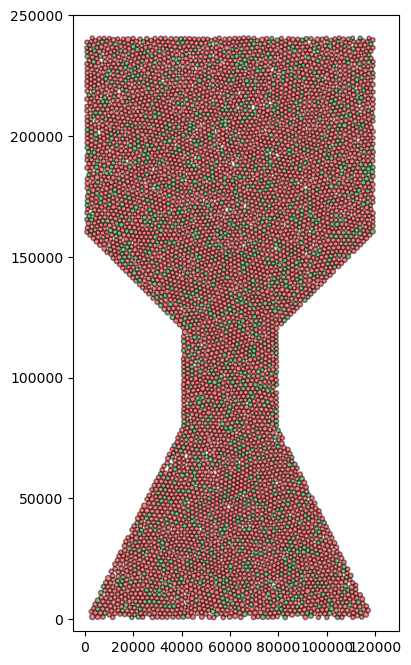

In [13]:
fig, ax = plt.subplots(figsize = (8,8))

for index, row in df2_fixed.iterrows():
    color = 'red' if np.isin(index, olap) else 'g' # i think this code is messed up.....
    circle = plt.Circle((row['x'], row['y']), row['d']/2, edgecolor ='k', facecolor = color, alpha = 0.5)
    ax.add_artist(circle)

ax.set_xlim(-5e3, 130e3)
ax.set_ylim(-5e3, 250e3)
# ax.set_xlim(40e3, 80e3)
# ax.set_ylim(80e3, 100e3)
ax.set_aspect('equal')
plt.show()

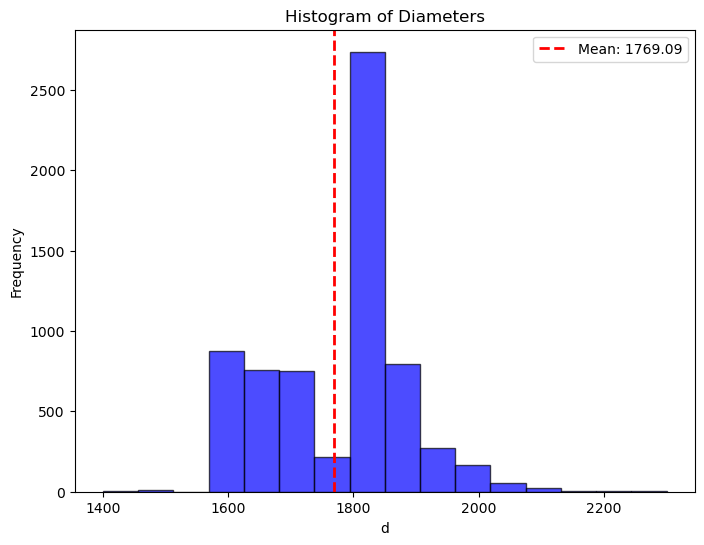

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df2_fixed['d'], bins=16, color='blue', edgecolor='black', alpha=0.7)
ax.axvline(df2_fixed['d'].mean(), color='red', linestyle='--', linewidth=2,
        label=f'Mean: {df2_fixed['d'].mean():.2f}')
ax.set_xlabel('d')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Diameters')
ax.legend()

nearly gaussian ... wayyy better. still slow though.

In [ ]:
def compute_max_growth_for_particle(i, positions, radii, df_bdy, bdy_radius, tol):
    current_r = radii[i]
    allowed_growth = np.inf
    # check distance among other particles
    for j in range(len(radii)):
        if i == j:
            continue
        d_ij = np.linalg.norm(positions[i] - positions[j])
        allowed_growth = min(allowed_growth, (d_ij - (radii[i] + radii[j]) + tol) / 2)
    # check distance w/ boundaries
    for _, bdy in df_bdy.iterrows():
        d_bdy = np.linalg.norm(positions[i] - np.array([bdy['x'], bdy['y']]))
        allowed_growth = min(allowed_growth, d_bdy - (radii[i] + bdy_radius) + tol)
    return allowed_growth

def update_radii_asynchronous(df, df_bdy, bdy_radius = 2000, tol=1e-5, min_growth_rate=0.1):
    """
    Asynchronously update each particle's radius by its maximum safe growth increment,
    iterating until no particle can grow by at least min_growth_rate.
    """
    while True:
        positions = df[['x','y']].to_numpy()
        radii = 0.5*df['d'].to_numpy()
        # compute allowed growth for each particle
        allowed_growths = np.array([compute_max_growth_for_particle(i, positions, radii, df_bdy, bdy_radius, tol)
                                     for i in range(len(radii))])
        # stop if below the growth rate (note that bond skin must be longer than this min_growth_rate)
        if np.all(allowed_growths < min_growth_rate):
            break
        # update particle diameters
        df['d'] += 2*allowed_growths   
    return df


In [51]:
original_fpath = 'data/packing2km.data'

# Read atom data until we hit velocities
column_names = ['type', 'x', 'y', 'z', 'd', 'density']
rows_to_skip = 21
cutoff_line = None
with open(original_fpath, 'r') as f:
    for i, line in enumerate(f):
        if "Velocities" in line:
            cutoff_line = i - 1
            break
rows_to_read = cutoff_line - rows_to_skip if cutoff_line is not None else None
df3 = pd.read_csv(original_fpath, sep=r'\s+', usecols=[1, 2, 3, 4, 5, 6],
                skiprows=rows_to_skip, nrows=rows_to_read,
                names=column_names)

# Reformat dataframe so we're ready to read it out
df3["id"] = range(1, len(df3) + 1)
df3 = df3.set_index("id")
df3["bond_type"] = 1

# (2) Set parameters to install bonds on fake atoms to allow successful import
# These will be deleted upon import so overlap is ok
d = 2000                          # hard coding be careful!!!
density = 920   # hard coding be careful!!!

# (2) Get boundary particles
#df_bdy = get_bdy_particles_coords(d)

# (3) Fix Overlaps

# 3.1 Delete atoms at the very edge that got uplifted
df3 = df3[df3['z'] <= -4000] # careful of hard coding here!!!! number from visual inspection in Ovito
df3.index = range(1, len(df3) + 1) # reindex dataframe so that fix overlaps still works

In [55]:
def remove_initial_overlaps(df, tol=1e-5):
    """
    Remove initial overlaps by uniformly shrinking particle radii.
    Assumes df has columns 'x', 'y', and 'd' (diameter).
    This updates df in place by computing a shrink amount so that even the worst overlap is removed.
    """
    positions = df[['x', 'y']].to_numpy()
    # Compute initial radii from diameters.
    radii = df['d'].to_numpy() / 2.0
    tree = cKDTree(positions)
    delta_required = 0.0
    # Use a search radius that covers all possible overlaps.
    max_possible = np.max(radii) * 2
    overlap_pairs = tree.query_pairs(r=max_possible)
    for i, j in overlap_pairs:
        d_ij = np.linalg.norm(positions[i] - positions[j])
        # Overlap amount if they are overlapping.
        overlap = (radii[i] + radii[j]) - d_ij
        if overlap > 0:
            # Each particle should lose half of the overlap.
            delta_required = max(delta_required, overlap / 2)
    if delta_required > 0:
        shrink_amount = delta_required + tol  # add a small extra for safety
        print(f"Initial overlap detected. Shrinking all radii by {shrink_amount:.4f} m.")
        new_radii = radii - shrink_amount
        df['radius'] = new_radii
        df['d'] = 2 * new_radii
    else:
        df['radius'] = radii
        print("No initial overlaps detected.")
    return df


In [56]:
df3_noolap = remove_initial_overlaps(df3)
df3_fixed = update_radii_asynchronous(df3_noolap, df_bdy)

Initial overlap detected. Shrinking all radii by 263.7680 m.


In [57]:
# Check for any overlap
olap = check_all_overlaps(df3_fixed)
print(len(olap))
overlap = np.unique(olap)
print(len(overlap), 'overlaps found')

1702.589766578903
5038
5038 overlaps found


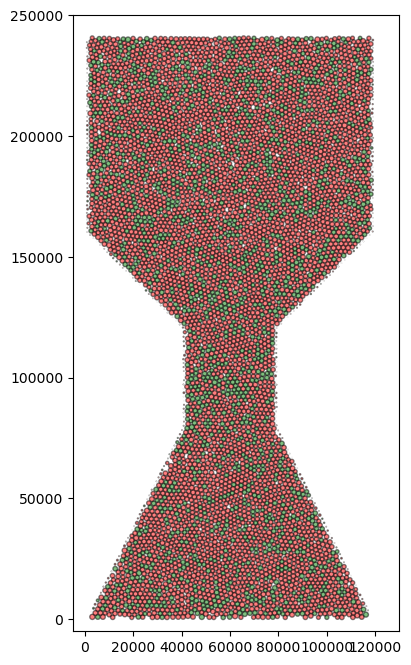

In [58]:
fig, ax = plt.subplots(figsize = (8,8))

for index, row in df3_fixed.iterrows():
    color = 'red' if np.isin(index, olap) else 'g' # i think this code is messed up.....
    circle = plt.Circle((row['x'], row['y']), row['d']/2, edgecolor ='k', facecolor = color, alpha = 0.5)
    ax.add_artist(circle)

ax.set_xlim(-5e3, 130e3)
ax.set_ylim(-5e3, 250e3)
# ax.set_xlim(40e3, 80e3)
# ax.set_ylim(80e3, 100e3)
ax.set_aspect('equal')
plt.show()

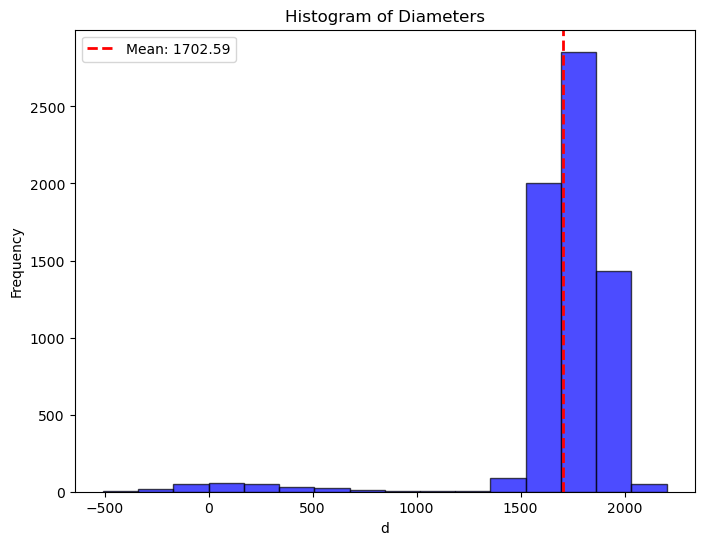

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df3_fixed['d'], bins=16, color='blue', edgecolor='black', alpha=0.7)
ax.axvline(df3_fixed['d'].mean(), color='red', linestyle='--', linewidth=2,
        label=f'Mean: {df3_fixed['d'].mean():.2f}')
ax.set_xlabel('d')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Diameters')
ax.legend()